In [79]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

In [80]:
# In this example we work with a = 7 and N = 15
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [81]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

## Performing measurement on each step

In [82]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

In [155]:
# Defining backend 
from qiskit import IBMQ
# IBMQ.load_account()
IBMQ.providers() 
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
cloud_backend = provider.get_backend('ibmq_qasm_simulator')

In [156]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends() 

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

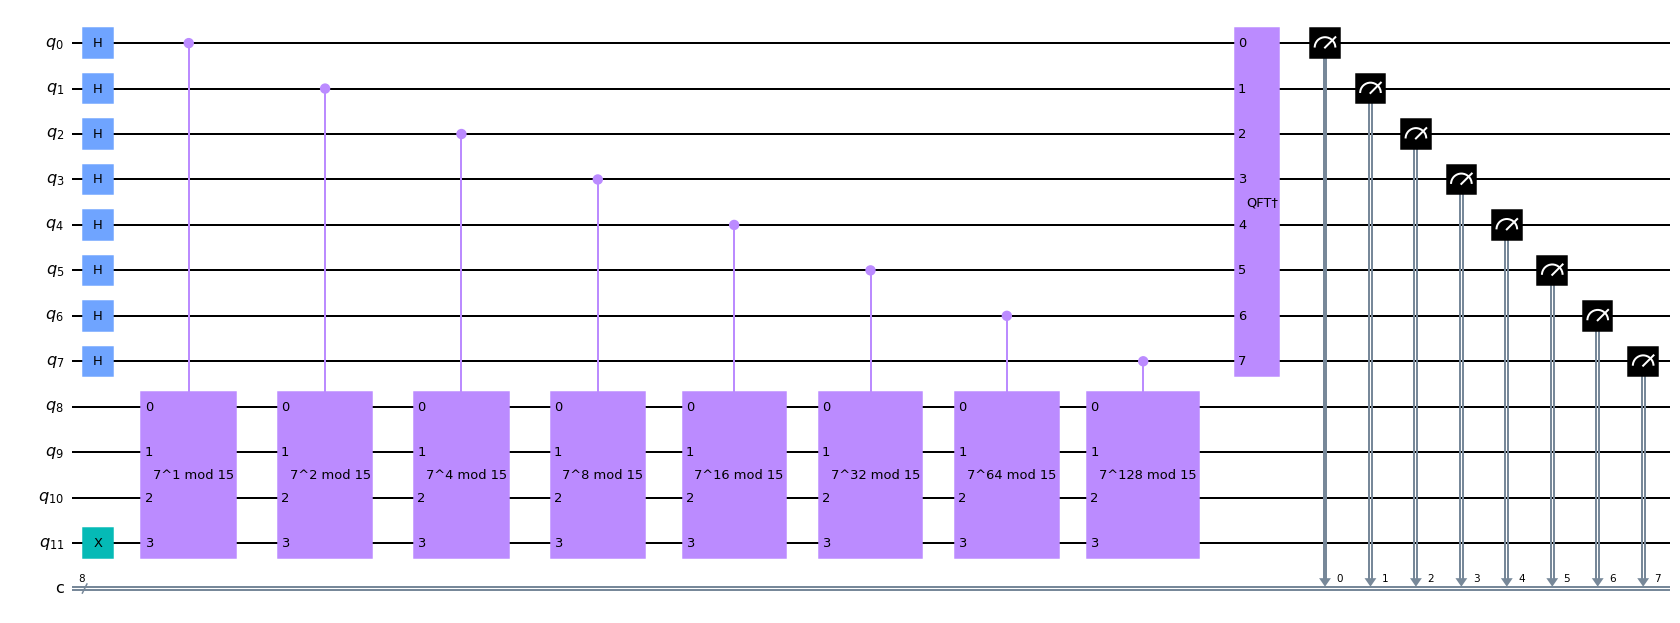

In [164]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc_tq = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc_tq.h(q)
    
# And auxiliary register in state |1>
qc_tq.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc_tq.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc_tq.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc_tq.measure(range(n_count), range(n_count))
# qc_tq.measure_all()
qc_tq.draw("mpl",fold = -1) 

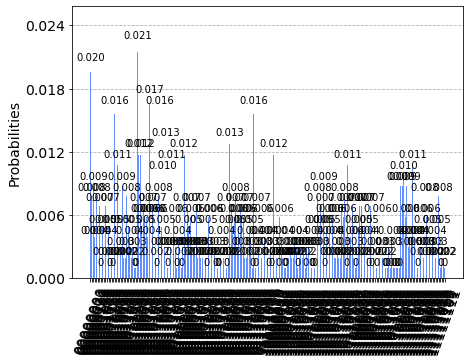

In [175]:
# from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
# from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

from qiskit.test.mock import FakeMelbourne
backend = FakeMelbourne()

# Build noise model from backend properties
# provider = IBMQ.load_account()
# backend = provider.get_backend('ibmq_16_melbourne')
noise_model = NoiseModel.from_backend(backend)


# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates


# Perform a noise simulation
result = execute(qc_tq, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [187]:
counts

{'01111100': 1,
 '00000111': 1,
 '00011110': 1,
 '01010111': 1,
 '01110001': 1,
 '00001101': 1,
 '01010101': 1,
 '10110011': 1,
 '00111110': 1,
 '10100101': 1,
 '10011010': 4,
 '01001110': 2,
 '11111011': 1,
 '00010100': 3,
 '11101111': 2,
 '11001011': 2,
 '00001111': 1,
 '01110101': 2,
 '11001101': 1,
 '11001001': 1,
 '01100101': 3,
 '11011011': 1,
 '10011000': 3,
 '00010111': 2,
 '11110100': 2,
 '11010011': 3,
 '11011001': 1,
 '11111111': 1,
 '01011010': 4,
 '11011111': 1,
 '11010100': 2,
 '11100110': 4,
 '00110011': 3,
 '10011100': 1,
 '10101101': 3,
 '00001110': 2,
 '10111100': 1,
 '00100111': 4,
 '10111011': 2,
 '01011000': 2,
 '10101110': 2,
 '00111101': 2,
 '01000110': 3,
 '10011101': 1,
 '11110010': 5,
 '01000011': 5,
 '11001000': 7,
 '01000111': 3,
 '11001100': 3,
 '00100101': 6,
 '11000001': 7,
 '10001001': 2,
 '10000001': 2,
 '01101101': 5,
 '00000010': 9,
 '11110111': 2,
 '00101010': 7,
 '10010000': 4,
 '11110000': 8,
 '01011101': 1,
 '01010001': 6,
 '00111100': 4,
 '101000

In [178]:
# declaring an empty list
listr = []
 
# appending all the values in the list
for value in counts.values():
    listr.append(value)
sum(listr)

1024

In [186]:
listr = []
 
# appending all the values in the list
for value in counts.values():
    listr.append(value/1024)
# Standard deviation of list
# Using sum() + list comprehension
mean = sum(listr) / len(listr)
variance = sum([((x - mean) ** 2) for x in listr]) / len(listr)
res = variance ** 0.5
print(res)

0.003475207274696011


In [183]:
counts['11000000']

5

## Time measurement for the model with noise

In [140]:
def qpe_amod15(a, backend):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
     
#     t_qc = transpile(qc, backend)
#     result = aer_sim.run(t_qc, shots=1, memory=True).result()
#     readings = result.get_memory()
    
    
    job_sim = execute(qc,backend)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
    output = max(counts, key=counts.get)

    print("Best option " + output)
    phase = int(output,2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [141]:
phase = qpe_amod15(a,cloud_backend) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Best option 01000000
Corresponding Phase: 0.250000


Fraction(1, 4)

In [142]:
def get_results(a,N,backend):
    factor_found = False
    attempt = 0
    while not factor_found:
        attempt += 1
        print("\nAttempt %i:" % attempt)
        phase = qpe_amod15(a,backend) # Phase = s/r
        frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
        r = frac.denominator
        print("Result: r = %i" % r)
        if phase != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
            print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
            for guess in guesses:
                if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                    print("*** Non-trivial factor found: %i ***" % guess)
                    factor_found = True
    pass

In [143]:
import time
start = time.time()
get_results(7,15,cloud_backend)
end = time.time()
print("Time for succefull factorization is  ",end - start," sec")


Attempt 1:
Best option 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***
Time for succefull factorization is   19.52422070503235  sec


## Density matrix attempts

In [ ]:
psi_AB = qi.Statevector.from_instruction(qc)
psi_AB.draw('latex',prefix='|\\psi_{AB}\\rangle = ')

In [ ]:
rho_AB = qi.DensityMatrix.from_instruction(qc_AB)
rho_AB.draw('latex', prefix='\\rho_{AB} = ')

In [ ]:
from qiskit.visualization import plot_state_city
plot_state_city(rho_AB.data, title='Density Matrix')